In [ ]:
!pip install neuron
!pip install netpyne


In [2]:
import os
import matplotlib

In [3]:
if os.path.isdir('/content/neuron_model_two'):
  !rm -rf /content/neuron_model_two


In [ ]:
!git clone https://github.com/josemendez-villanueva/neuron_model_two.git

In [ ]:
%cd neuron_model_two

In [ ]:
!nrnivmodl mod/

In [ ]:
%ls

In [8]:
#This will be the importing section of the cells and setting up the populationg/cell/netowrk

from netpyne import specs, sim

netParams = specs.NetParams()
cfg = specs.SimConfig()


#Population Paramters
cfg.P1_pop = 20
cfg.P2_pop = 20
cfg.P3_pop = 20
cfg.G_pop = 15

cfg.prob1 = .8
cfg.prob2 = .5


cfg.prob_G_0 = .5
cfg.prob_G_1 = .5
cfg.prob_G_2 = .5



netParams.sizeX = 100
netParams.sizeY = 1000
netParams.sizeZ = 100
netParams.propVelocity = 100.0

CellRule = netParams.importCellParams(
        label='Golgi_Cell_Rules',
        conds= {'cellType': 'GoC', 'cellModel': 'GoC_Solinas'},
        fileName='mod/Golgi_template.hoc',
        cellName='Goc')


#For simplicity purposes will be creating a dummy pyramidal cell (Not of Golgi type) in order to first test a few things

netParams.cellParams['PYR'] = {
    'secs': {'soma':
            {'geom': {'diam': 18.8, 'L': 18.8, 'Ra': 123.0},
            'mechs': {'hh': {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -70}}}},
            'dend':
            {'geom': {'diam': 5.0, 'L': 150.0, 'Ra': 150.0, 'cm': 1},
            'mechs': {'pas': {'g': 0.0000357, 'e': 0}}}}

# Create Population Parameter

netParams.popParams['P1'] = {'cellType': 'PYR', 'numCells': cfg.P1_pop}
netParams.popParams['P2'] = {'cellType': 'PYR', 'numCells': cfg.P2_pop}
netParams.popParams['P3'] = {'cellType': 'PYR', 'numCells': cfg.P3_pop}
netParams.popParams['Golgi'] = {'cellModel': 'GoC_Solinas', 'cellType': 'GoC', 'numCells': cfg.G_pop}


#Create Stimulation

netParams.stimSourceParams['Input_1'] = {'type': 'VClamp', 'dur': [0, 50, 100], 'amp': [-60, -30, 40], 'gain': 1e5, 'rstim': 1, 'tau1': 0.1, 'tau2': 0}
netParams.stimTargetParams['Input_1->P1'] = {'source': 'Input_1', 'sec':'soma', 'loc': 0.8, 'conds': {'pop':'P1'}}
###Create Background Noise as well since it should be present###
netParams.stimSourceParams['background'] = {'type': 'NetStim', 'rate': 10, 'noise': 0.8}
netParams.stimTargetParams['background->Pop'] = {'source': 'background', 'conds': {'cellType': 'PYR'}, 'weight': 0.03, 'delay': 10, 'synMech': 'exc'}

#Create Synapses

netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 1.0, 'tau2': 5.0, 'e': 0}


#Connections


netParams.connParams['P1->P2'] = { 
        'preConds': {'pop': 'P1'},     # presynaptic conditions
        'postConds': {'pop': 'P2'},    # postsynaptic conditions
        'probability': cfg.prob1,           # probability of connection
        'weight': 0.01,               # synaptic weight
        'delay': 5,                   # transmission delay (ms)
        'sec': 'dend',                # section to connect to
        'loc': 1.0,                   # location of synapse
        'synMech': 'exc'}             # target synaptic mechanism

netParams.connParams['P2->P3'] = { 
        'preConds': {'pop': 'P2'},     
        'postConds': {'pop': 'P3'},  
        'probability': cfg.prob2,           
        'weight': 0.01,           
        'delay': 5,               
        'sec': 'dend',              
        'loc': 1.0,                  
        'synMech': 'exc'}       

netParams.connParams['P1->Golgi'] = { 
        'preConds': {'pop': 'P2'},     
        'postConds': {'pop': 'Golgi'},  
        'probability': cfg.prob_G_0,           
        'weight': 0.01,           
        'delay': 5,               
        'sec': 'dend_0',              
        'loc': 1.0,                  
        'synMech': 'exc'} 

netParams.connParams['P2->Golgi'] = { 
        'preConds': {'pop': 'P2'},     
        'postConds': {'pop': 'Golgi'},  
        'probability': cfg.prob_G_1,           
        'weight': 0.01,           
        'delay': 5,               
        'sec': 'dend_1',              
        'loc': 1.0,                  
        'synMech': 'exc'} 

netParams.connParams['P2->Golgi'] = { 
        'preConds': {'pop': 'P2'},     
        'postConds': {'pop': 'Golgi'},  
        'probability': cfg.prob_G_2,           
        'weight': 0.01,           
        'delay': 5,               
        'sec': 'dend_2',              
        'loc': 1.0,                  
        'synMech': 'exc'} 

netParams.connParams['Golgi->Golgi'] = { 
        'preConds': {'pop': 'Golgi'},     
        'postConds': {'pop': 'Golgi'},  
        'probability': .4,           
        'weight': 0.01,           
        'delay': 5,               
        'sec': 'dend_0',              
        'loc': 1.0,                  
        'synMech': 'exc'} 



In [9]:
%matplotlib inline

In [10]:
#Simulation

cfg.duration = 1*1e3      # Duration of the simulation, in ms
cfg.dt = 0.025              # Internal integration timestep to use
cfg.verbose = False         # Show detailed messages
cfg.recordCells = {'all'}
cfg.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
cfg.recordStep = 0.1        # Step size in ms to save data (eg. V traces, LFP, etc)
cfg.filename = 'output'       # Set file output name
cfg.saveJson = False
cfg.printPopAvgRates = False



cfg.analysis['plotRaster'] = {'saveFig': True}                   # Plot a raster
cfg.analysis['plotTraces'] = {'include': [0], 'saveFig': True}  # Plot recorded traces for this list of cells
cfg.analysis['plot2Dnet'] = {'saveFig': True} 
cfg.analysis['plotConn'] = {'saveFig': True}

cfg.saveDataInclude = ['simData', 'simConfig', 'netParams', 'net']




Start time:  2021-05-29 07:59:39.925765

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 75 
  Done; cell creation time = 0.04 s.
Making connections...
  Number of connections on node 0: 753 
  Number of synaptic contacts on node 0: 912 
  Done; cell connection time = 0.11 s.
Adding stims...
  Number of stims on node 0: 80 
  Done; cell stims creation time = 0.01 s.
Recording 75 traces of 1 types on node 0

Running simulation for 1000.0 ms...
  Done; run time = 12.52 s; real-time ratio: 0.08.

Gathering data...
  Done; gather time = 0.10 s.

Analyzing...
  Cells: 75
  Connections: 813 (10.84 per cell)
  Synaptic contacts: 972 (12.96 per cell)
  Spikes: 1439 (19.19 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 12.52 s
  Done; saving time = 0.02 s.
Plotting raster...


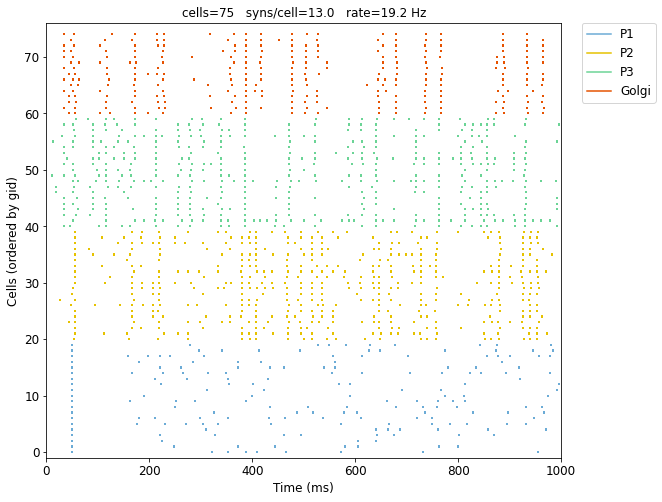

Plotting recorded cell traces ... cell


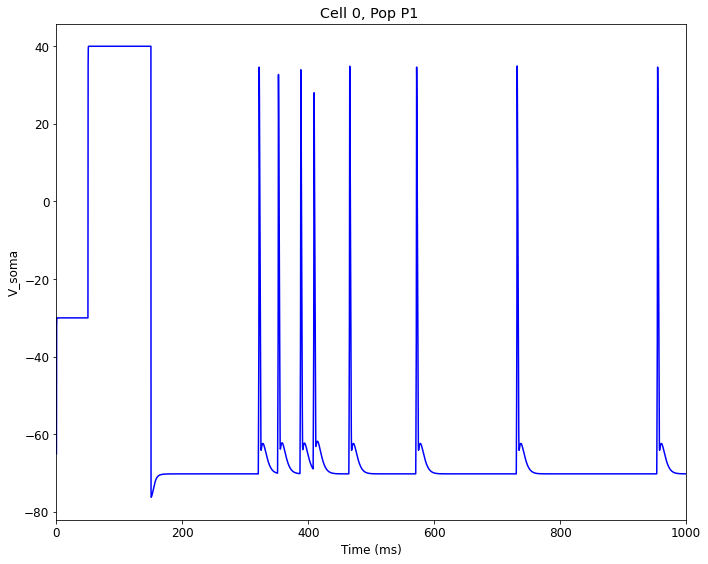

Plotting 2D representation of network cell locations and connections...


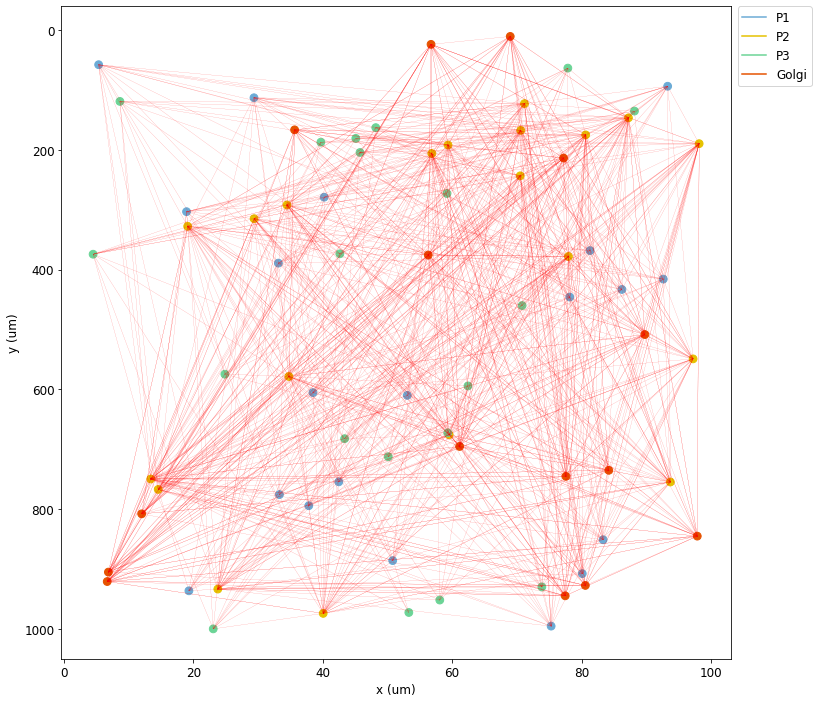

Plotting connectivity matrix...


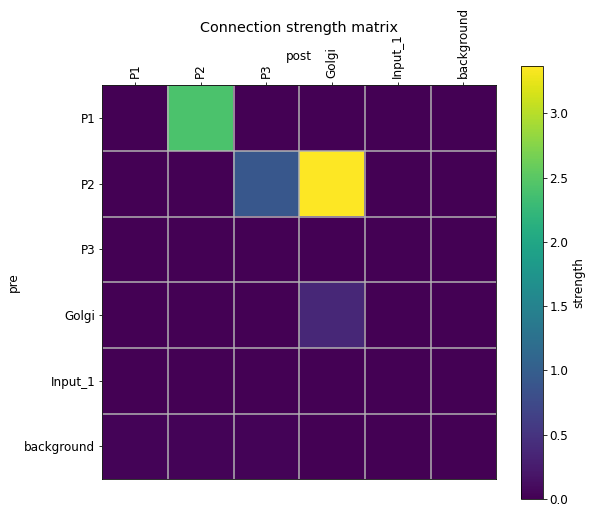

  Done; plotting time = 3.67 s

Total time = 16.48 s

End time:  2021-05-29 07:59:56.408855

Reading command line arguments using syntax: python file.py [simConfig=filepath] [netParams=filepath]

This usually occurs when cfg.py crashes.  Please ensure that your cfg.py file
completes successfully on its own (i.e. execute "python cfg.py" and fix any bugs).

This usually occurs when netParams.py crashes.  Please ensure that your netParams.py file
completes successfully on its own (i.e. execute "python netParams.py" and fix any bugs).


In [11]:
%matplotlib inline
sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg)
simConfig, netParams = sim.readCmdLineArgs(simConfigDefault='cfg.py', netParamsDefault='netParams.py')